# PREDICTING THE ACCURACY OF CITIZEN COLLECTED BIODIVERSITY DATA

#### We share our plant with 20-30 billion species, and each individual species is a treasure trove of data. The food we eat, the plants in our gardens and even some of the most important medicines in human history are a product of other living species. Biodiversity is akin to a library that we are only beginning to understand and this library can hold the key to some of the most important problems in the future. It is then, imperative that we effectively document this data, to understand, which species share our planet and where there occur so we can catalog the valuable information around us. 

## The iNaturalist application

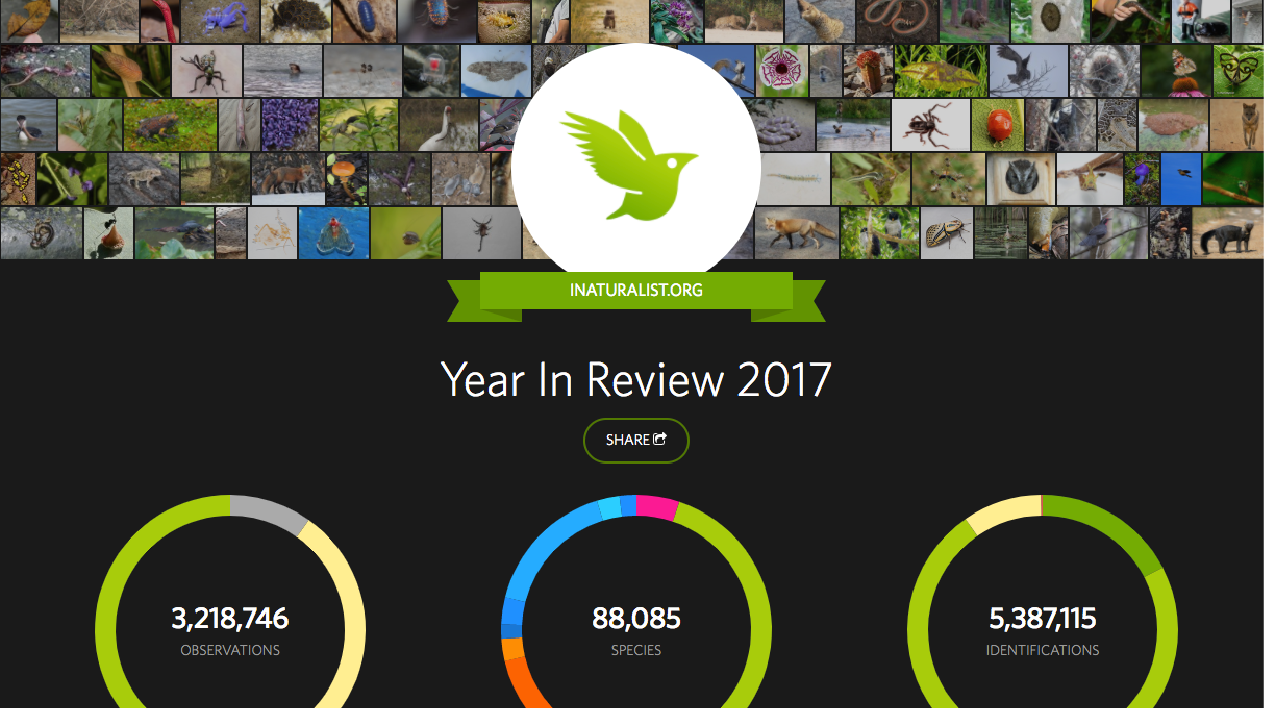

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("iNat.png", height=500, width=1000)

#### iNaturalist is a mobile application run by the California Academy of Sciences that allows people to upload photos and information on species (plant and animals) they observe in their daily life. It is a fantastic appliation that relies of regular people, who look at birds in their garden or hike the National Parks of America to document and collect biodiversity data. However,  not everyone is an expertly trained biologist, and some organisms are inherently diificult to identify. 

#### Here, I develop a machine learning model to predict which observations are likely to be correctly identified. My classifier can determine which observations need additional expert identification and can tag those that are likely to be correct.  

In [2]:
%matplotlib inline
import urllib2
import numpy as np
import json
import pandas as pd
pd.set_option("display.max_columns",999)
from pandas.io.json import json_normalize
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
import plotly as py
import plotly.graph_objs as go
py.tools.set_credentials_file(username='tjogesh', api_key='jQCndI6d5M1oYF4mXX7i')

## The iNaturalist dataset 

#### The iNatualist dataset is extremely large so to effectively explore this data, I will use Spark. 

In [4]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()

In [5]:
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)

#### I limit the data set to 10,000 records collected between 2016-2017 across the continental United States. 

In [6]:
start_pg = 1
num_recs = 10000
total_records = 10000
per_page = 1
step = 1

#### The API takes a long time to download the data, which is in json format. I download a single observation as an individual json file so that the schema is easier to infer with Spark Dataframes

In [7]:
#%run 'Download_iNat_data.ipynb'

In [8]:
#sparkdf = sqlsc.createDataFrame(iNat_df_main)
data = sqlsc.read.json('data/*')

In [9]:
#data.rdd.getNumPartitions()

#### A lot of the data in the original dataframe table is nested and a lot is irrelavent so I will just select columns that are important for the analysis

In [10]:
cols = ['page',
              'per_page',
              'total_results',
              'results.annotations',
              'results.comments',
              'results.created_at',
              'results.created_at_details',
              'results.created_time_zone',
              'results.description',
              'results.faves',
              'results.flags',
              'results.geoprivacy',
              'results.identifications',
              'results.license_code',
              'results.non_owner_ids',
              'results.oauth_application_id',
              'results.observation_photos',
              'results.observed_on',
              'results.ofvs',
              'results.observed_on_string',
              'results.observed_time_zone',
              'results.outlinks',
              'results.photos',
              'results.place_ids',
              'results.preferences',
              'results.project_ids',
              'results.project_ids_with_curator_id',
              'results.project_ids_without_curator_id',
              'results.project_observations',
              'results.quality_metrics',
              'results.reviewed_by',
              'results.sounds',
              'results.tags',
              'results.time_observed_at',
              'results.time_zone_offset',
              'results.updated_at',
              'results.uri',
              'results.uuid',
              'results.votes']
subset = data.select([c for c in data.columns if c not in cols])
#data.drop(cols)

In [11]:
from pyspark.sql import functions as F
t = subset.select("results.cached_votes_total",
                'results.comments_count',
                'results.community_taxon_id',
                'results.observed_on_details.day',
                'results.observed_on_details.hour',
                'results.observed_on_details.month',
                'results.observed_on_details.week',
                'results.observed_on_details.year',
                'results.faves_count',
                'results.geojson.coordinates',
                'results.geojson.type',
                'results.id',
                'results.id_please',
                'results.identifications_count',
                'results.identifications_most_agree',
                'results.identifications_most_disagree',
                'results.identifications_some_agree',
                'results.mappable',
                'results.owners_identification_from_vision',
                'results.quality_grade',
                'results.species_guess',
                'results.taxon.complete_rank',
                'results.taxon.introduced',
                'results.taxon.iconic_taxon_name',
                'results.taxon.min_species_ancestry',
                'results.taxon.observations_count',
                'results.taxon.rank',
                'results.taxon.extinct',
                'results.taxon.threatened',
                'results.user.activity_count',
                subset['results.user.identifications_count'].alias('user_identifications_count')
                   )


In [12]:
t.printSchema()

root
 |-- cached_votes_total: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- comments_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- community_taxon_id: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- day: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- hour: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- month: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- week: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- year: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- faves_count: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- coordinates: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- type: array (nullable = true)
 |    |-- element: string (containsNull = tr

In [13]:
t.cache()

DataFrame[cached_votes_total: array<bigint>, comments_count: array<bigint>, community_taxon_id: array<bigint>, day: array<bigint>, hour: array<bigint>, month: array<bigint>, week: array<bigint>, year: array<bigint>, faves_count: array<bigint>, coordinates: array<array<string>>, type: array<string>, id: array<bigint>, id_please: array<boolean>, identifications_count: array<bigint>, identifications_most_agree: array<boolean>, identifications_most_disagree: array<boolean>, identifications_some_agree: array<boolean>, mappable: array<boolean>, owners_identification_from_vision: array<boolean>, quality_grade: array<string>, species_guess: array<string>, complete_rank: array<string>, introduced: array<boolean>, iconic_taxon_name: array<string>, min_species_ancestry: array<string>, observations_count: array<bigint>, rank: array<string>, extinct: array<boolean>, threatened: array<boolean>, activity_count: array<bigint>, user_identifications_count: array<bigint>]

In [14]:
df=t.toPandas()

#### This step of converting to pandas and back to spark df helps cut down computation time because of lazy evaluation and the fact that all values are stored as lists. Spark performs much better and faster without the lists. 

In [15]:
df_clean=df.applymap(lambda x: x[0] if x !=[] else None)

In [16]:
df_clean.head()

,cached_votes_total,comments_count,community_taxon_id,day,hour,month,week,year,faves_count,coordinates,type,id,id_please,identifications_count,identifications_most_agree,identifications_most_disagree,identifications_some_agree,mappable,owners_identification_from_vision,quality_grade,species_guess,complete_rank,introduced,iconic_taxon_name,min_species_ancestry,observations_count,rank,extinct,threatened,activity_count,user_identifications_count
0,0.0,0.0,NaN,27.0,0.0,12.0,52.0,2016.0,0.0,"[-80.8573150635, 25.2178111166]",Point,9496140.0,False,0.0,False,False,False,True,True,needs_id,Eastern Phoebe,species,False,Aves,"48460,1,2,355675,3,7251,15984,17007,17008",5543.0,species,False,False,853.0,30.0
1,0.0,0.0,218914.0,10.0,10.0,8.0,32.0,2016.0,0.0,"[-82.072222, 46.218394]",Point,9495068.0,False,1.0,True,False,True,True,False,research,Bicolored Moth,None,False,Insecta,"48460,1,47120,372739,47158,184884,47157,47607,...",35.0,species,False,False,495.0,122.0
2,0.0,0.0,145217.0,5.0,9.0,5.0,18.0,2016.0,0.0,"[-81.810474, 24.546755]",Point,9490765.0,False,1.0,True,False,True,True,False,research,Tennessee Warbler,species,False,Aves,"48460,1,2,355675,3,7251,71349,144406,145217",602.0,species,False,False,755.0,16.0
3,0.0,0.0,354685.0,31.0,9.0,7.0,30.0,2016.0,0.0,"[-60.553798, 46.299432]",Point,9481972.0,False,1.0,True,False,True,True,True,research,Pococera maritimalis,None,False,Insecta,"48460,1,47120,372739,47158,184884,47157,49682,...",34.0,species,False,False,2718.0,812.0
4,0.0,0.0,67771.0,9.0,12.0,11.0,45.0,2016.0,0.0,"[-119.1310214996, 50.8110195082]",Point,9035503.0,False,1.0,True,False,True,True,False,research,Punaise américaine,None,False,Insecta,"48460,1,47120,372739,47158,184884,47744,61267,...",981.0,species,False,False,729.0,521.0


In [3]:
#option to store the data as a csv file
#df_clean.to_csv('out.csv',encoding='utf-8', index=False)
#df_clean=pd.read_csv('out.csv')

In [17]:
main = sqlsc.createDataFrame(df_clean)

In [18]:
main.printSchema()

root
 |-- cached_votes_total: double (nullable = true)
 |-- comments_count: double (nullable = true)
 |-- community_taxon_id: double (nullable = true)
 |-- day: double (nullable = true)
 |-- hour: double (nullable = true)
 |-- month: double (nullable = true)
 |-- week: double (nullable = true)
 |-- year: double (nullable = true)
 |-- faves_count: double (nullable = true)
 |-- coordinates: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- type: string (nullable = true)
 |-- id: double (nullable = true)
 |-- id_please: boolean (nullable = true)
 |-- identifications_count: double (nullable = true)
 |-- identifications_most_agree: boolean (nullable = true)
 |-- identifications_most_disagree: boolean (nullable = true)
 |-- identifications_some_agree: boolean (nullable = true)
 |-- mappable: boolean (nullable = true)
 |-- owners_identification_from_vision: boolean (nullable = true)
 |-- quality_grade: string (nullable = true)
 |-- species_guess: string (nullable = 

In [19]:
main.cache()

DataFrame[cached_votes_total: double, comments_count: double, community_taxon_id: double, day: double, hour: double, month: double, week: double, year: double, faves_count: double, coordinates: array<string>, type: string, id: double, id_please: boolean, identifications_count: double, identifications_most_agree: boolean, identifications_most_disagree: boolean, identifications_some_agree: boolean, mappable: boolean, owners_identification_from_vision: boolean, quality_grade: string, species_guess: string, complete_rank: string, introduced: boolean, iconic_taxon_name: string, min_species_ancestry: string, observations_count: double, rank: string, extinct: boolean, threatened: boolean, activity_count: double, user_identifications_count: double]

## Commonly reported Species

In [20]:
species= main.groupby('species_guess').count().toPandas() 

In [21]:
species.head()

,species_guess,count
0,Sandhill Crane,11
1,Acorn Woodpecker,11
2,Rabbitfoot grass,1
3,Ilia Underwing,2
4,Common Gray,5


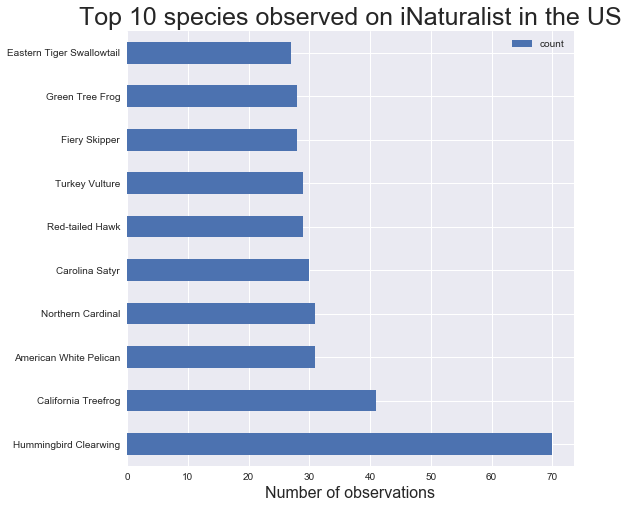

In [22]:

species.dropna(inplace=True)
## Sort values based on count and plot the top 10 most commonly observed species
species[['species_guess','count']].set_index('species_guess').sort_values('count', ascending=False).head(10).plot(kind='barh', figsize=(8, 8))
plt.title('Top 10 species observed on iNaturalist in the US', fontsize = 25)
plt.xlabel('Number of observations', fontsize = 16)
plt.ylabel("")
plt.show()

Hummingbird Clearwing


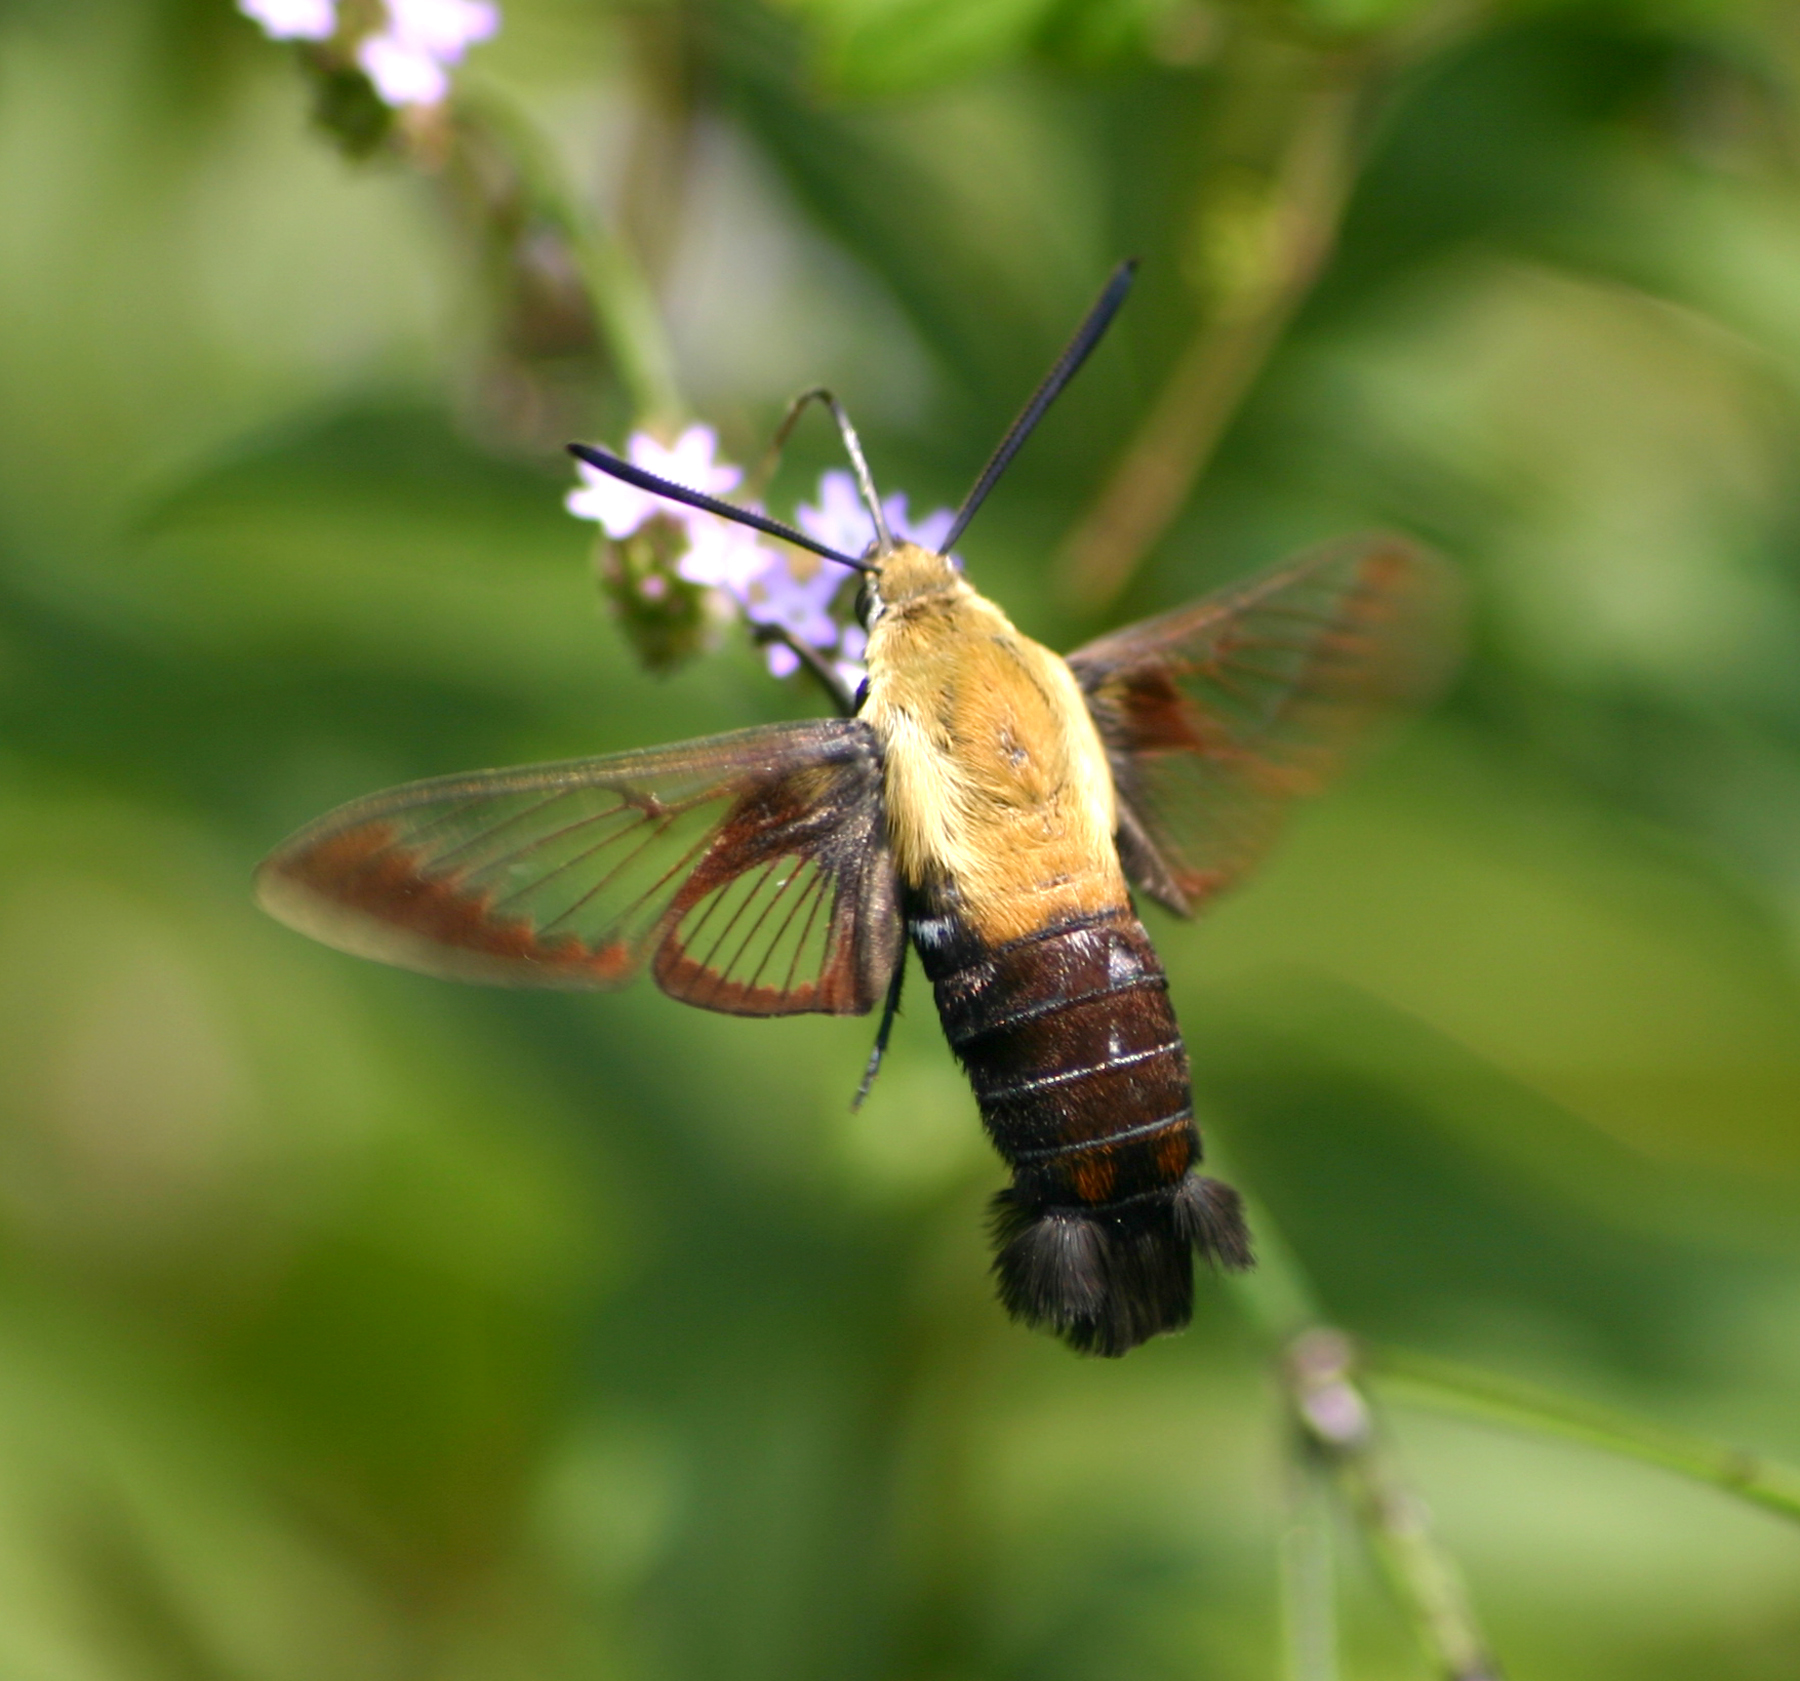

In [23]:
print "Hummingbird Clearwing"
Image("Humming.jpg", height=250, width=500)
#By Pollinator at English Wikipedia, CC BY 2.5, https://commons.wikimedia.org/w/index.php?curid=45907003

### A little moth, called the hummingbird clearwing is the most commonly encoutered and documented species in US. Why? These moths are not the most common moths but may be one of the most commonly photographed, probably because they are beautiful and look like small hummingbirds. This data suggests that observations on iNaturalist are likely to be biased in favor of species that are more charismatic. Indeed, 80% of the top 10 list are birds and butterflies! 

In [24]:
rank= main.groupby('rank').count().toPandas() 

In [25]:
rank

,rank,count
0,species,9392
1,infrahybrid,1
2,subspecies,387
3,form,2
4,hybrid,7
5,variety,59
6,None,1


In [26]:
taxa = main.groupby('iconic_taxon_name').count().toPandas() 

In [27]:
labels = list(taxa.iconic_taxon_name)
values = list(taxa['count'])

fig = {
    'data': [{'labels': labels,
              'values': values,
              'type': 'pie'}],
    'layout': {'title': 'Major organismal groups observed on iNaturalist'}
     }

py.plotly.iplot(fig, filename='taxa_on_iNat')


### Insects, Birds and Plants comprise the bulk of observations on iNaturalist. Insects and Plants are extrememly diverse and ubiquitous so it is not surprising that they are commonly reported on iNaturalist. Birds are not nearly as diverse but have a long history of human documentation. Observing birds or "Birding" is a common hobby for many Americans. 

## Features that predict the accurancy of a Species ID

#### The online community on iNaturalist actively verifies the species identification of observations. This information can be used to effectively classify which observations are accurate versus those thar are incorrect. Here I explore whether any other features are associated with a correct identification.   

In [28]:
df_means= main.groupby('identifications_most_agree').agg({'cached_votes_total': 'mean',
                                                 'comments_count': 'mean',
                                                 'faves_count': 'mean',
                                                 'observations_count': 'mean',
                                                 'activity_count': 'mean',
                                                 'user_identifications_count': 'mean'
                                                 }).toPandas() 

In [29]:
# fill 
df_means.dropna(inplace=True)

In [30]:
df_means['ID']=["Correct","Incorrect"]
df_means.columns=['identifications_most_agree','User_activity',
 'Num_Votes_on_observation',
 'Num_comments',
 'Num_favorites',
 'Num_taxa_Identified_by_user',
 'Num_times_taxa_observed',
 'ID']

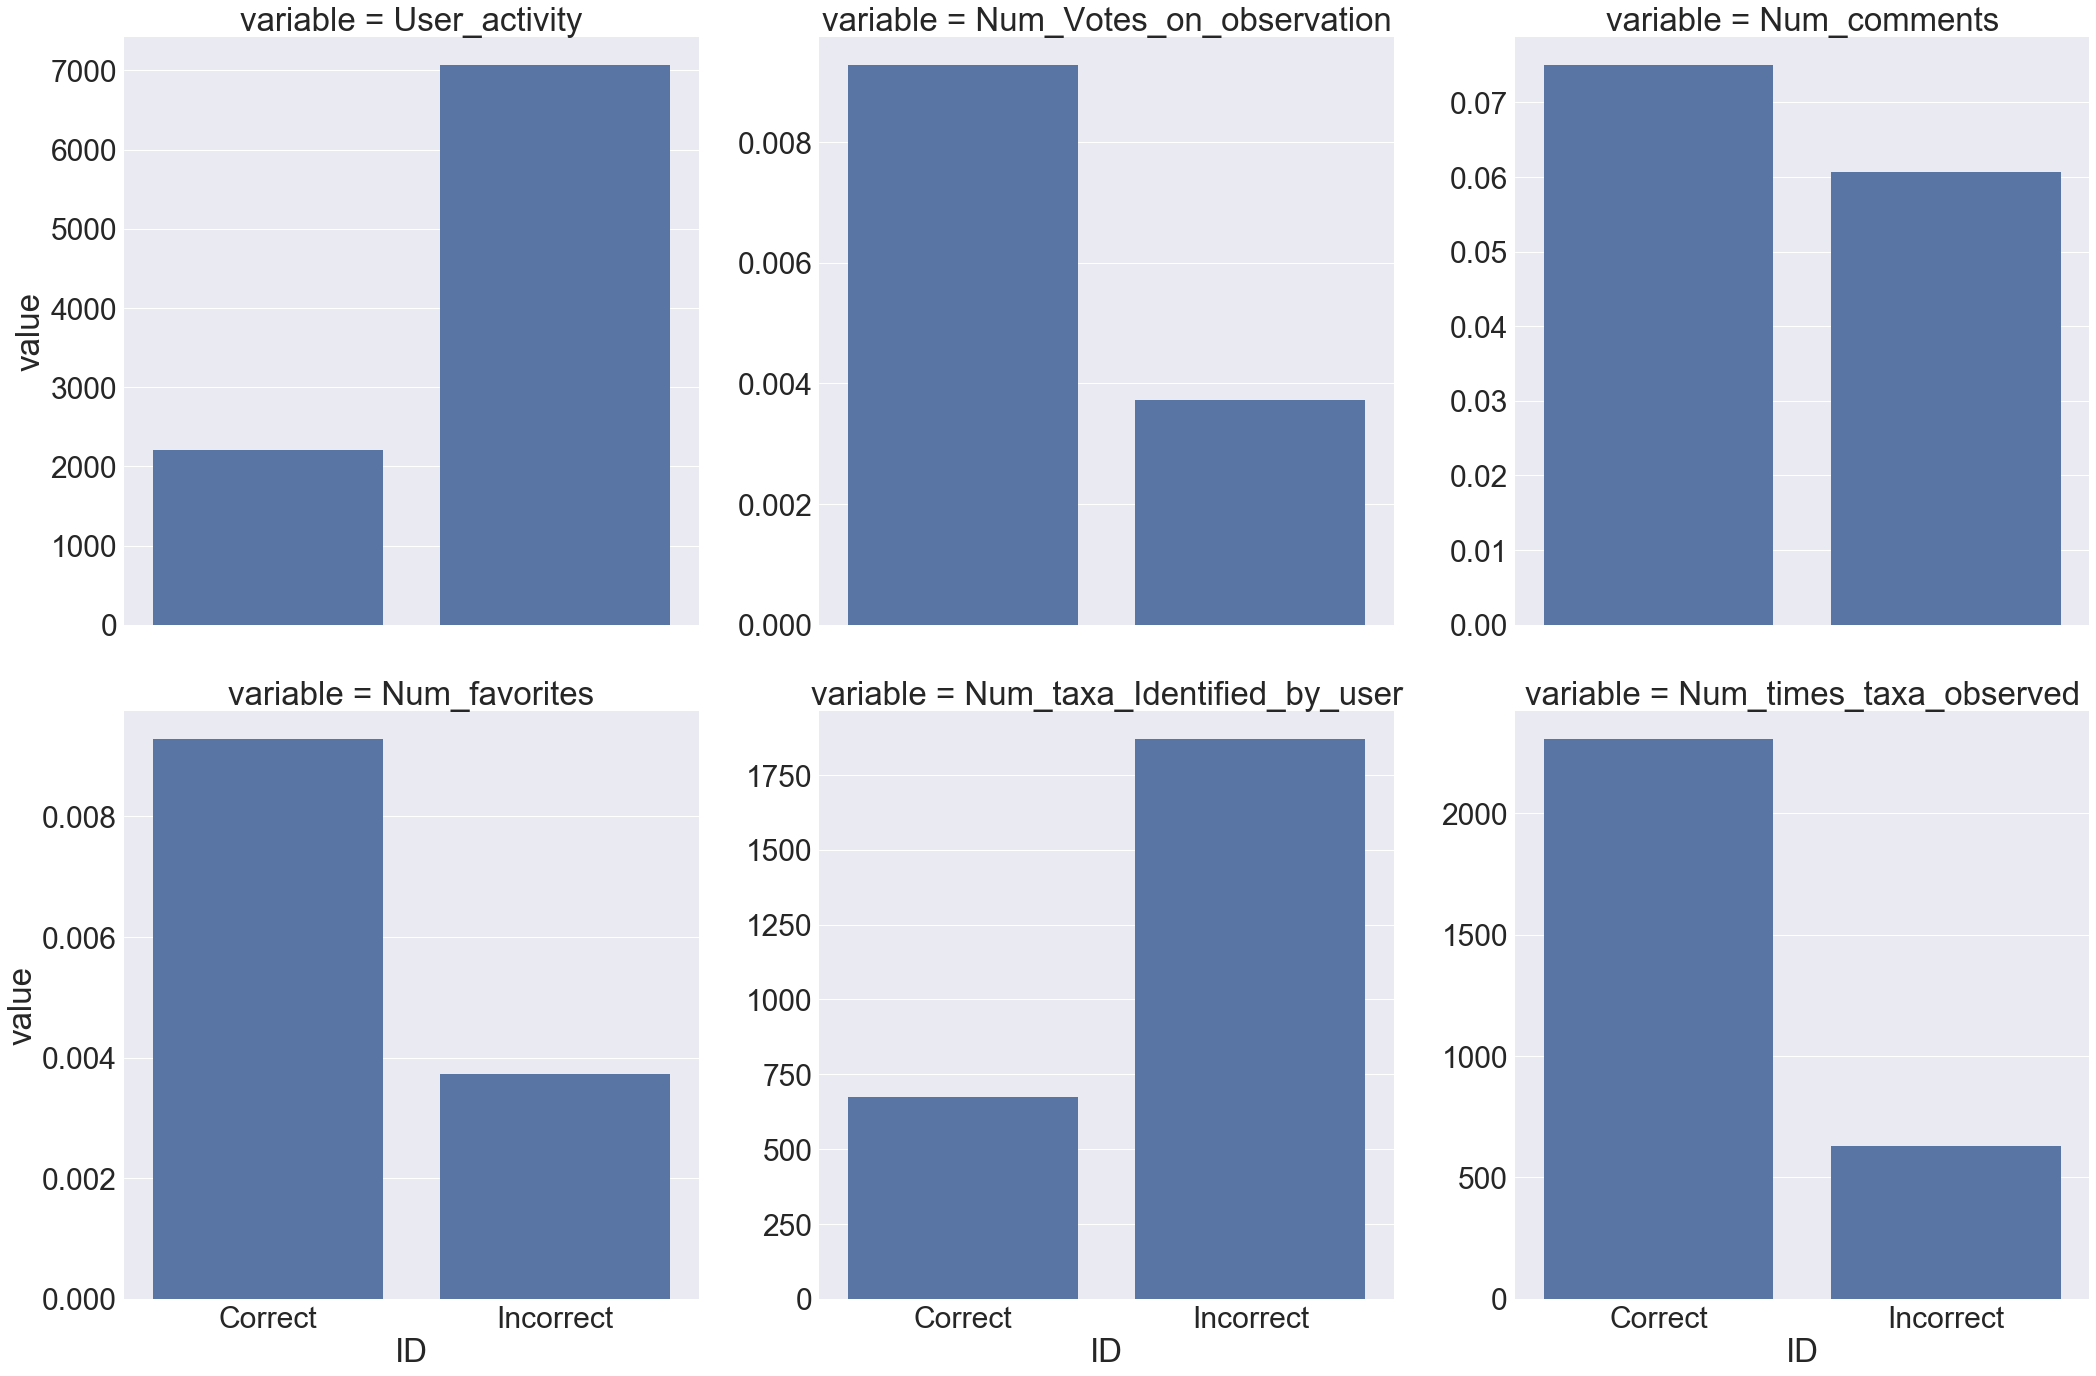

In [31]:
df_means_long = pd.melt(df_means.drop('identifications_most_agree', axis=1), id_vars=['ID'])
sns.set(font_scale=3)
g = sns.FacetGrid(df_means_long, col="variable", sharey=False, size = 10, aspect = 1, col_wrap=3)
g = (g.map(sns.barplot, 'ID','value'))
plt.show()

### Correctly identified taxa have more votes, favorites and comments by the user community and these taxa are commonly observed on iNaturalist. Counterintuitively, active users and users that more frequently ID observations on iNaturalist tend to post more misidentified observations. Thus popular taxa = increased odds of correct ID and frequent users = increased odds of an incorrect ID!

### the month and week of the year 

In [32]:
df_month= main.crosstab('month', 'identifications_most_agree').toPandas() 

In [33]:
df_month['prop_correct'] = df_month['true']/(df_month['true']+df_month['false'])
df_month['prop_incorrect'] = 1-df_month['prop_correct'] 
df_month.sort_values('prop_correct',inplace=True)
#df_month['month_identifications_most_agree']=df_month['month_identifications_most_agree'].astype('int64')
month_dict ={'0.0':'null','1.0':'Jan', '2.0':'Feb', '3.0':'March', '4.0':'April', '5.0':'May',
             '6.0':'June', '7.0':'July', '8.0':'August','9.0':'Sept', '10.0':'Oct','11.0':'Nov', 
             '12.0':'Dec' }
df_month['month']=df_month['month_identifications_most_agree'].replace(month_dict)

In [34]:
df_month.dropna(inplace=True)

In [35]:
labels = df_month['month']

trace1 = go.Bar(
    y=labels,
    x=list(df_month.prop_correct),
    name='Correctly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    y=labels,
    x=list(df_month.prop_incorrect),
    name='Incorrectly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='marker-h-bar1')

### Observations posted in June, September and October have greater than 20% misidentifications. 

In [36]:
df_hour= main.crosstab('hour', 'identifications_most_agree').toPandas() 

In [37]:
df_hour['prop_correct'] = df_hour['true']/(df_hour['true']+df_hour['false'])
df_hour['prop_incorrect'] = 1-df_hour['prop_correct'] 

hour_dict ={'0.0':None,'1.0':'1am', '2.0':'2am', '3.0':'3am', '4.0':'4am', '5.0':'5am',
             '6.0':'6am', '7.0':'7am', '8.0':'8am','9.0':'9am', '10.0':'10am','11.0':'11am', 
            '12.0':'noon',
            '13.0':'1pm','14.0':'2pm', '15.0':'3pm', '16.0':'4pm', '17.0':'5pm', '18.0':'6pm',
             '19.0':'7pm', '20.0':'8pm', '21.0':'9pm','22.0':'10pm', '23.0':'11pm',
            '24.0':'midnight'}
df_hour['hour']=df_hour['hour_identifications_most_agree'].replace(hour_dict)
df_hour.sort_values('prop_correct',inplace=True)

In [38]:
df_hour.dropna(inplace=True)

In [39]:
labels = df_hour['hour']

trace1 = go.Bar(
    y=labels,
    x=list(df_hour.prop_correct),
    name='Correctly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    y=labels,
    x=list(df_hour.prop_incorrect),
    name='Incorrectly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='marker-h-bar2')

### Observations late in the evening 8pm-10pm tend to be misidentified. Surprisingly, observations in the middle of the night (2am etc) have a low rate of misidentification, however, fewer observations made at these hours. 

In [40]:
df_owner_id= main.crosstab('owners_identification_from_vision', 'identifications_most_agree').toPandas() 

In [41]:
df_owner_id.replace('null', np.nan, inplace=True)
df_owner_id.drop('null', axis =1, inplace=True)
df_owner_id.dropna(inplace=True)
df_owner_id

,owners_identification_from_vision_identifications_most_agree,true,false
0,false,5159,1495
1,true,2685,359


In [42]:
df_owner_id['prop_correct'] = df_owner_id['true']/(df_owner_id['true']+df_owner_id['false'])
df_owner_id['prop_incorrect'] = 1-df_owner_id['prop_correct'] 
labels = ['NotFromVision','FromVision']

trace1 = go.Bar(
    y=labels,
    x=list(df_owner_id.prop_correct),
    name='Correctly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    y=labels,
    x=list(df_owner_id.prop_incorrect),
    name='Incorrectly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='marker-h-bar3')

### Species that are identified from vision are likely just easier to identify and thus frequently accurate identifications

In [43]:
df_quality= main.crosstab('quality_grade', 'identifications_most_agree').toPandas() 
df_quality=df_quality[df_quality['quality_grade_identifications_most_agree']!='null']

In [44]:
df_quality['prop_correct'] = df_quality['true']/(df_quality['true']+df_quality['false'])
df_quality['prop_incorrect'] = 1-df_quality['prop_correct'] 
labels = df_quality['quality_grade_identifications_most_agree']

trace1 = go.Bar(
    y=labels,
    x=list(df_quality.prop_correct),
    name='Correctly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    y=labels,
    x=list(df_quality.prop_incorrect),
    name='Incorrectly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='marker-h-bar4')

### A research grade is assigned when more than 2/3 of identifiers agree on a taxon. Thus the research grade is a near identical measure of accuracy.  Casual observation don't have photos and are not georeferences, thus making it impossible to confirm the ID of the observation. 

In [45]:
df_native= main.crosstab('introduced', 'identifications_most_agree').toPandas() 

In [46]:
df_native=df_native[df_native['introduced_identifications_most_agree']!='null']
df_native

,introduced_identifications_most_agree,true,null,false
0,false,7693,0,1808
1,true,277,0,70


In [47]:
df_native['ID']=['native','introduced']
df_native['prop_correct'] = df_native['true']/(df_native['true']+df_native['false'])
df_native['prop_incorrect'] = 1-df_native['prop_correct'] 
labels = df_native['ID']

trace1 = go.Bar(
    y=labels,
    x=list(df_native.prop_correct),
    name='Correctly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    y=labels,
    x=list(df_native.prop_incorrect),
    name='Incorrectly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='marker-h-bar5')

### Whether the organism is native to the US or introduced from elsewhere doesn't influence the frequency of misidentification

In [48]:
df_threat= main.crosstab('threatened', 'identifications_most_agree').toPandas() 

In [49]:
df_threat=df_threat[df_threat['threatened_identifications_most_agree']!='null']
df_threat

,threatened_identifications_most_agree,true,null,false
0,false,7433,0,1815
1,true,537,0,63


In [50]:
df_threat['ID']=['threatened','not threatened']
df_threat['prop_correct'] = df_threat['true']/(df_threat['true']+df_threat['false'])
df_threat['prop_incorrect'] = 1-df_threat['prop_correct'] 
labels = df_threat['ID']

trace1 = go.Bar(
    y=labels,
    x=list(df_threat.prop_correct),
    name='Correctly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    y=labels,
    x=list(df_threat.prop_incorrect),
    name='Incorrectly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='marker-h-bar')

### threatend taxa are more frequently misidentified

In [51]:
#t.select('community_taxon_id').distinct().count()

In [52]:
taxa_id = main.crosstab('iconic_taxon_name', 'identifications_most_agree').toPandas() 

In [53]:
taxa_id=taxa_id[taxa_id['iconic_taxon_name_identifications_most_agree']!='null']

In [54]:
taxa_id['prop_correct'] = taxa_id['true']/(taxa_id['true']+taxa_id['false'])
taxa_id['prop_incorrect'] = 1-taxa_id['prop_correct'] 
taxa_id.sort_values('prop_correct',inplace=True)

In [55]:
names = ['Algae','Microbes','Fungi','Plants',
         'Other Animals','Spiders','Molluscs','Amphibians',
         'Insects','Fish','Mammals','Reptiles','Birds']
taxa_id['name'] = names

In [56]:
labels = list(taxa_id.name)

trace1 = go.Bar(
    y=labels,
    x=list(taxa_id.prop_correct),
    name='Correctly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    y=labels,
    x=list(taxa_id.prop_incorrect),
    name='Incorrectly Identified',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='marker-h-bar6')

### Some organisms are just easier to identify. Unsurprisingly, small organisms like fungi, microbes, and algae are frequently misidentified whereas bigger organisms like birds replites and mammal are often correctly identified. 

## Is there a geographic trend? 

In [57]:
#geo_data.toPandas()

In [58]:
from pyspark.sql.types import DoubleType
main = main.withColumn("long_num", main["coordinates"].getItem(1).cast(DoubleType()))
main = main.withColumn("lat_num", main["coordinates"].getItem(0).cast(DoubleType()))

### First, I need to get state and country data from Lat/Long data by reverse geocoding

In [59]:
import reverse_geocoder as rg
def get_state(coord=(0,0)): 
    results = rg.search(coord)
    return results[0]['admin1']
        
def get_country(coord=(0,0)): 
    results = rg.search(coord)
    return results[0]['cc']


In [60]:
df_clean['lat']=df_clean['coordinates'].map(lambda x: x[0] if x !=None else None)
df_clean['lat'] =pd.to_numeric(df_clean['lat'])
df_clean['long']=df_clean['coordinates'].map(lambda x: x[1] if x !=None else None)
df_clean['long'] =pd.to_numeric(df_clean['long'])

In [61]:
df_clean['lat'].fillna(0, inplace=True)
df_clean['long'].fillna(0, inplace=True)
df_clean['latlong'] = zip(df_clean['long'],df_clean['lat'])

In [62]:
df_clean['state'] = df_clean['latlong'].apply(get_state)

Loading formatted geocoded file...


In [63]:
ids_state =pd.crosstab(df_clean.state,df_clean.identifications_most_agree)
ids_state.reset_index(inplace=True)
ids_state.columns = ['state','False','True']
ids_state['prop_correct'] = ids_state['True']/(ids_state['True']+ids_state['False'])

In [64]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}
ids_state['state_abv']=ids_state['state'].replace(us_state_abbrev)

In [65]:
scl = [[0.0, 'rgb(0, 51, 204)'],[0.4, 'rgb(51, 153, 255)'],[0.6, 'rgb(204, 204, 255)'],\
            [0.8, 'rgb(255, 204, 204)'],[1.0, 'rgb(153, 0, 0)']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = ids_state['state_abv'],
        text=ids_state['True'],
        z = ids_state['prop_correct'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Proportion correctly Identified")
        ) ]

layout = dict(
        title = 'iNaturalist accurate IDs by state',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.plotly.iplot( fig, filename='d3-cloropleth-map' )


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tjogesh/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


### There are differences in the accuracies by state. Interestingly states with few observations like UT, ND, AR tend to have low identification (UT, ND, WY) accuracy. The number of observations are also a lot higher in the west compared to th east. 

## ---------------------------------------
## FEATURE ENGINEERING FOR ML
## ---------------------------------------

#### Coding categorical variables as numerical values 

In [5]:
cols_to_drop =['community_taxon_id',
               'year',
               'coordinates',
               'type',
               'id',
               'identifications_count',
               'identifications_most_disagree',
               'identifications_some_agree',
               'quality_grade',
               'species_guess',
               'complete_rank',
               'min_species_ancestry', 
               'extinct',
               'lat',
               'long',
               'latlong']

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

features=df_clean.copy()
features.drop(cols_to_drop, axis =1, inplace=True)
features.dropna(inplace=True, axis=0)

features.month = label_encoder.fit_transform(features['month'])
features.day = label_encoder.fit_transform(features['day'])
features.hour = label_encoder.fit_transform(features['hour'])
features.week = label_encoder.fit_transform(features['week'])
features.id_please = label_encoder.fit_transform(features['id_please'])
features.mappable = label_encoder.fit_transform(features['mappable'])
features.owners_identification_from_vision = label_encoder.fit_transform(features['owners_identification_from_vision'])
features.threatened = label_encoder.fit_transform(features['threatened'])
features.iconic_taxon_name = label_encoder.fit_transform(features['iconic_taxon_name'])
features.introduced = label_encoder.fit_transform(features['introduced'])
features['rank'] = label_encoder.fit_transform(features['rank'])
features.state = label_encoder.fit_transform(features['state'])
features.identifications_most_agree = label_encoder.fit_transform(features['identifications_most_agree'])

#only one missing value so drop it
Y=features['identifications_most_agree'].values
X_label= features.drop('identifications_most_agree', axis =1).values


#### Coding categorical variables in a sparse matrix 

In [7]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

month = encoder.fit_transform(features[['month']]).toarray()
day = encoder.fit_transform(features[['day']]).toarray()
hour = encoder.fit_transform(features[['hour']]).toarray()
week = encoder.fit_transform(features[['week']]).toarray()
id_please = encoder.fit_transform(features[['id_please']]).toarray()
mappable = encoder.fit_transform(features[['mappable']]).toarray()
owners_identification_from_vision = encoder.fit_transform(features[['owners_identification_from_vision']]).toarray()
threatened = encoder.fit_transform(features[['threatened']]).toarray()
iconic_taxon_name = encoder.fit_transform(features[['iconic_taxon_name']]).toarray()
introduced = encoder.fit_transform(features[['introduced']]).toarray()
frank = encoder.fit_transform(features[['rank']]).toarray()
state = encoder.fit_transform(features[['state']]).toarray()
identifications_most_agree = encoder.fit_transform(features[['identifications_most_agree']]).toarray()
numeric_cols = ['cached_votes_total','comments_count','faves_count',
                'observations_count','activity_count','user_identifications_count']
numeric_features = features[numeric_cols].values

Y=features['identifications_most_agree'].values
X_sparse=np.concatenate([month,day,hour,week,id_please,
                  mappable,owners_identification_from_vision,
                  threatened,iconic_taxon_name,introduced,
                  frank,state,numeric_features], axis=1)


## ------------------------------------------------------
##  MACHINE LEARNING CLASSIFIERS
## ------------------------------------------------------

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.model_selection import KFold

## Random forest classifier

#### numerically labelled catergoical features  

In [9]:

start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X_label,Y, test_size=0.30)
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit(xtrain, ytrain)
training_accuracy = forest.score(xtrain, ytrain)
test_accuracy = forest.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))

Accuracy on training data: 0.996906
Accuracy on test data:     0.885911
--- 1.16860485077 seconds processing time---


ROC AUC: 0.88


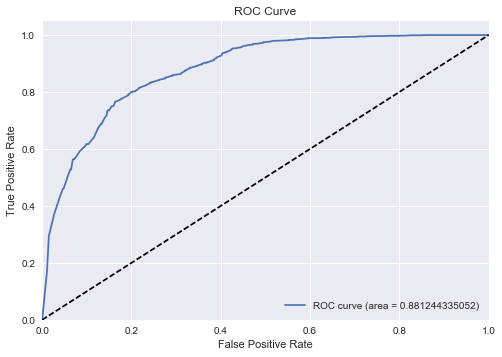

In [10]:

# Calculate the AUC
fpr, tpr, thresholds = roc_curve(ytest, forest.predict_proba(xtest)[:,1])
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

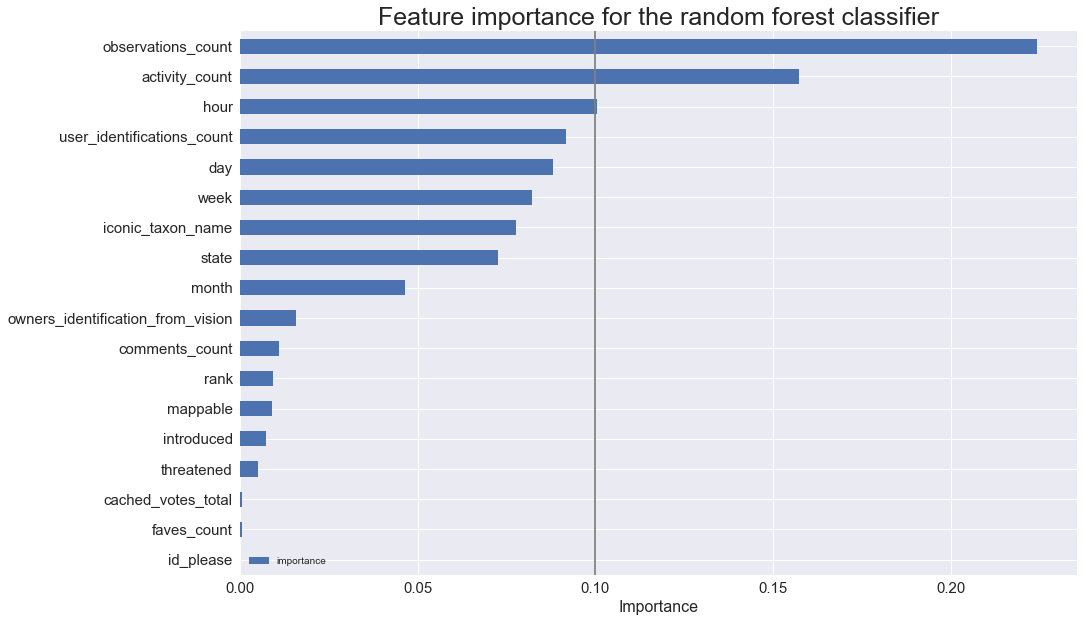

In [11]:
importances = forest.feature_importances_
feature_list = list(features.columns) 
feature_list.remove('identifications_most_agree')
feature_importance = pd.DataFrame(zip(feature_list, importances), columns = ('feature','importance'))
feature_importance.set_index('feature', inplace=True)
feature_importance.sort_values('importance').plot(kind='barh', figsize=(15, 10))
plt.axvline(0.1, color="gray")
plt.title('Feature importance for the random forest classifier', fontsize = 25)
plt.xlabel('Importance', fontsize = 16)
plt.ylabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()## Missing data

#### one hot encoded catergoical features  

In [12]:
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X_sparse,Y, test_size=0.30)
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit(xtrain, ytrain)
training_accuracy = forest.score(xtrain, ytrain)
test_accuracy = forest.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))

Accuracy on training data: 0.996464
Accuracy on test data:     0.881787
--- 2.1673951149 seconds processing time---


ROC AUC: 0.89


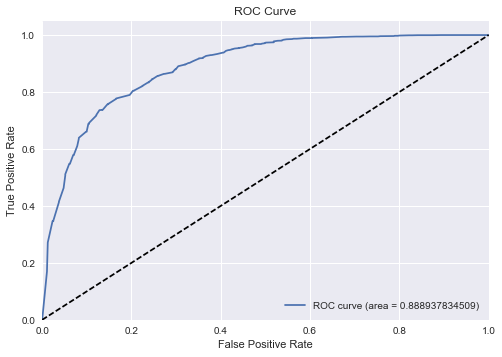

In [13]:
# Calculate the AUC
fpr, tpr, thresholds = roc_curve(ytest, forest.predict_proba(xtest)[:,1])
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### sparse matrices take longer to process and do not increasse the effectiveness of the classifier for RF models.  

## SVM classifier

In [14]:
#scale the data because SVMs perform better on scaled data
scaler = StandardScaler()
X = scaler.fit_transform(X_label)

#The grid search takes a really long time to run so I manually serached through a range of values. 
C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
## Too computatiomnally expensive to do a grid search
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
#grid.fit(X, Y)
#print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))


####  grid searching for C and gamma is too computationally expensive so I mannually search through a range of hyperparameters

In [76]:
## With labeled catergorical features C=0.01
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=0.01, gamma=1) 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))


Accuracy on training data: 0.820994
Accuracy on test data:     0.813157
--- 0.771466016769 seconds processing time---


In [77]:
## With labeled catergorical features C=0.1
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=1, gamma=1) 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))


Accuracy on training data: 0.812951
Accuracy on test data:     0.821200
--- 2.03750300407 seconds processing time---


In [78]:
## With labeled catergorical features C=1
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=1, gamma=1) 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))


Accuracy on training data: 0.814188
Accuracy on test data:     0.819963
--- 1.73508501053 seconds processing time---


In [79]:
## With labeled catergorical features C=100
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=100, gamma=1) 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))


Accuracy on training data: 0.815632
Accuracy on test data:     0.818519
--- 59.1335101128 seconds processing time---


In [80]:
## With labeled catergorical features gamma=0.001
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=1, gamma=0.001) 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))


Accuracy on training data: 0.817488
Accuracy on test data:     0.816663
--- 1.92390990257 seconds processing time---


In [15]:
## With labeled catergorical features gamma=100
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=1, gamma=100) 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))


Accuracy on training data: 0.818107
Accuracy on test data:     0.816045
--- 1.94378089905 seconds processing time---


In [25]:
## With labeled catergorical features gamma=100
X = scaler.fit_transform(X_sparse)
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=1, gamma=1) 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))


Accuracy on training data: 0.874201
Accuracy on test data:     0.837286
--- 21.8629519939 seconds processing time---


#### C and gamma don't change the accurancy by much and while SVM with a sparse matrix of categorical features is better, it does not perform nearly as well as the Random Forest model and is much, much slower

## Gradient Boosting Classifier

In [16]:
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X_label, Y, test_size=0.5,
                                                    random_state=9)

# Fit classifier with default parameters from sckitlearn
params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
GB_clf = ensemble.GradientBoostingClassifier(**params)
GB_model = GB_clf.fit(xtrain, ytrain)
test_accuracy = GB_clf.score(xtest, ytest)
train_accuracy = GB_clf.score(xtrain, ytrain)
print("Training accuracy: {:.4f}".format(train_accuracy))
print("Test accuracy: {:.4f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))

Training accuracy: 0.8864
Test accuracy: 0.8657
--- 4.87968420982 seconds processing time---


#### Grandient Boosting classifier performs much better than SVM but still not as well as the Random Forest Model but we still need to optimize the hyperparameters. 

#### Hyperparameter optimization for gradient boosting through individual grid searches

In [23]:
### optimization takes a long time to run. Change optimize to True if I want to reoptimize the model
optimize = False

In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(X_label, Y, test_size=0.5,
                                                    random_state=9)
if optimize == True:    
    #number if estimators
    params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}

    n_estimators = range(100,3001,1000)
    param_grid = dict(n_estimators=n_estimators)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    #max_depth
    params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    GB_clf = ensemble.GradientBoostingClassifier(**params)
    max_depth = range(3,10,3)
    param_grid = dict(max_depth=max_depth)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    #learning rate
    params = {'n_estimators': 1200, 'max_depth': 9, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    GB_clf = ensemble.GradientBoostingClassifier(**params)
    param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01]
                  }
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    #min_leaf_samples
    params = {'n_estimators': 1200, 'max_depth': 9, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    GB_clf = ensemble.GradientBoostingClassifier(**params)
    param_grid = {'min_samples_leaf':range(1,71,10)
                  }
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.7, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    
    #subsample
    params = {'n_estimators': 1200, 'max_depth': 9, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
    GB_clf = ensemble.GradientBoostingClassifier(**params)
    param_grid = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
                  }
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.7, random_state=42)
    grid = GridSearchCV(GB_clf, param_grid=param_grid, cv=cv)
    grid.fit(xtrain, ytrain)
    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    

#### one hot encoded catergoical features  

In [18]:
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X_sparse, Y, test_size=0.5,
                                                    random_state=9)

params = {'n_estimators': 1200, 'max_depth': 9, 'subsample': 0.6,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
GB_clf = ensemble.GradientBoostingClassifier(**params)
GB_model = GB_clf.fit(xtrain, ytrain)
test_accuracy = GB_clf.score(xtest, ytest)
train_accuracy = GB_clf.score(xtrain, ytrain)
print("Training accuracy: {:.4f}".format(train_accuracy))
print("Test accuracy: {:.4f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))

Training accuracy: 0.9876
Test accuracy: 0.8742
--- 136.398792982 seconds processing time---


#### No benefit to encoding the categorical variables as a sparse matrix and it takes longer to run 

#### Final GB Model 

In [19]:
start_time = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(X_label, Y, test_size=0.5,
                                                    random_state=9)

# Fit classifier with out-of-bag estimates
params = {'n_estimators': 1200, 'max_depth': 9, 'subsample': 0.6,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
GB_clf = ensemble.GradientBoostingClassifier(**params)
GB_model = GB_clf.fit(xtrain, ytrain)
test_accuracy = GB_clf.score(xtest, ytest)
train_accuracy = GB_clf.score(xtrain, ytrain)
print("Training accuracy: {:.4f}".format(train_accuracy))
print("Test accuracy: {:.4f}".format(test_accuracy))

print("--- %s seconds processing time---" % (time.time() - start_time))

Training accuracy: 0.9975
Test accuracy: 0.8717
--- 33.629046917 seconds processing time---


ROC AUC: 0.87


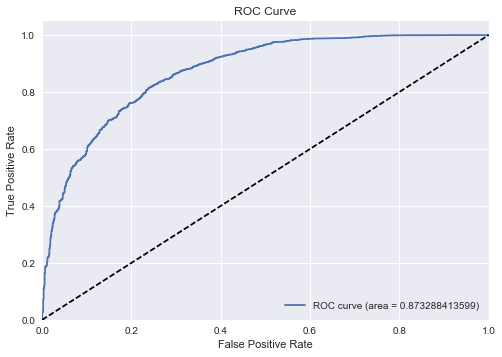

In [20]:
# Calculate the AUC
fpr, tpr, thresholds = roc_curve(ytest, GB_clf.predict_proba(xtest)[:,1])
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### While the optimization did impove accuracy, the random Forest model still performs better and faster than Gradient Boosting. 

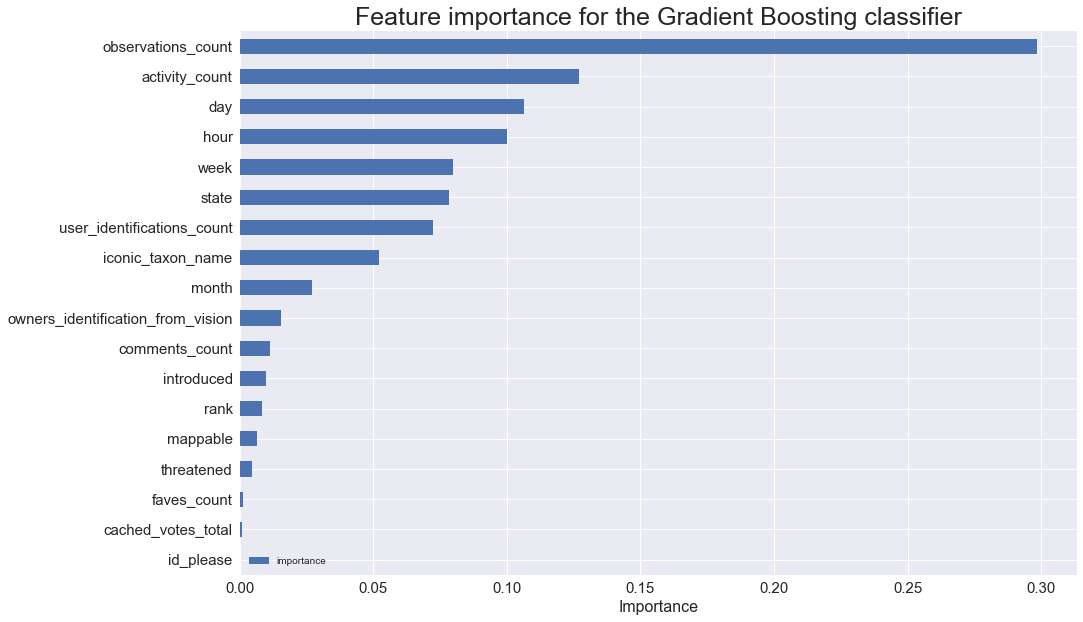

In [21]:
importances = GB_clf.feature_importances_
feature_list = list(features.columns) 
feature_list.remove('identifications_most_agree')
feature_importance = pd.DataFrame(zip(feature_list, importances), columns = ('feature','importance'))
feature_importance.set_index('feature', inplace=True)
feature_importance.sort_values('importance').plot(kind='barh', figsize=(15, 10))
plt.title('Feature importance for the Gradient Boosting classifier', fontsize = 25)
plt.xlabel('Importance', fontsize = 16)
plt.ylabel("")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()## Missing data

#### The important features in the GB model are pretty similar to the Random Forest model. The number of times a species is observed in iNaturalist is pretty predictive of how accuratly it is identified. This makes a lot of sense because common species should be both easily observed and identified. 